# Hierarchical Partial Pooling for Repeated Binary Trials

- BaseBall Hits: The source of this notebook the following page.
    - https://mc-stan.org/users/documentation/case-studies/pool-binary-trials.html
- Here I use numpyro instead of stan and R.

In [11]:
import argparse
import os

import jax
import jax.numpy as jnp
import jax.random as random
from jax.scipy.special import logsumexp

import numpyro
import numpyro as npr
import numpyro.distributions as dist
from numpyro.examples.datasets import BASEBALL, load_dataset
from numpyro.infer import HMC, MCMC, NUTS, SA, Predictive, log_likelihood
print(numpyro.__version__)

import matplotlib.pyplot as plt
import seaborn as sns
import arviz
import pandas as pd
import numpy as np
sns.set()
# plt.style.use('dark_background')
plt.style.use('seaborn-white')

0.6.0


In [2]:
assert numpyro.__version__.startswith('0.6.0')
num_samples = 5000
num_warmup  = 1500
algo = 'NUTS'  # 'HMC', 'NUTS', 'SA'
num_chains = 1
numpyro.set_host_device_count(num_chains)

In [3]:
def gomcmc(model, data_dict, num_samples=10000):
    rng_key = jax.random.PRNGKey(0)
    # run MCMC
    kernel = NUTS(model)
    mcmc = MCMC(kernel, num_warmup=1000, num_samples=num_samples, num_chains=1,
                progress_bar=False if "NUMPYRO_SPHINXBUILD" in os.environ else True)
    mcmc.run(rng_key, **data_dict)
    mcmc.print_summary(exclude_deterministic=False)
    return mcmc

In [4]:
def get_samples(mcmc):
    if isinstance(mcmc, dict):
        s = mcmc
    else:
        s = mcmc.get_samples()
    d = {}
    for k, v in s.items():
        if len(v.shape) == 2:
            for i in range(v.shape[1]):
                d[f'{k}_{i}'] = np.array(v[:,i])
        else: # len(v.shape) == 1
            d[k] = np.array(v)
    return d

## Data
- traint: at_bats, hits
- test: at_bats, hits
- The dataset separates the initial 45 at-bats statistics from the remaining season. 
- We use the hits data from the initial 45 at-bats to **estimate the batting average for each player**.
- We then use the remaining season's data to validate the predictions from our models.

In [5]:
_, fetch_train = load_dataset(BASEBALL, split='train', shuffle=False)
train, player_names = fetch_train()
_, fetch_test = load_dataset(BASEBALL, split='test', shuffle=False)
test, _ = fetch_test()
at_bats, hits = train[:, 0], train[:, 1]
season_at_bats, season_hits = test[:, 0], test[:, 1]
#
df = pd.DataFrame({'Player': player_names, 'AtBats': at_bats, 'Hits': hits, 
                   'RemainingAB': season_at_bats, 'RemainingHits': season_hits})
df

,Player,AtBats,Hits,RemainingAB,RemainingHits
0,Roberto Clemente,45,18,412,145
1,Frank Robinson,45,17,471,144
2,Frank Howard,45,16,566,160
3,Jay Johnstone,45,15,320,76
4,Ken Berry,45,14,463,128
5,Jim Spencer,45,14,511,140
6,Don Kessinger,45,13,631,168
7,Luis Alvarado,45,12,183,41
8,Ron Santo,45,11,555,148
9,Ron Swaboda,45,11,245,57


We will only need a few columns of the data; we will be using the remaining hits and at bats to evaluate the predictive inferences for the various models.

In [6]:
N = len(df)
K = df.AtBats
y = df.Hits
K_new = df.RemainingAB
y_new = df.RemainingHits

The data separates the outcome from the initial 45 at-bats from the rest of the season. After running this code, 
- `N` is the number of items (players). 
- Then for each item `n`, `K[n]` is the number of initial trials (at-bats), 
- `y[n]` is the number of initial successes (hits), 
- `K_new[n]` is the remaining number of trials (remaining at-bats), and 
- `y_new[n]` is the number of successes in the remaining trials (remaining hits).

The remaining data can be used to evaluate the predictive performance of our models conditioned on the observed data. That is, we will “train” on the first 45 at bats and see how well our various models do at predicting the rest of the season.

## Pooling
- With `complete pooling`, each item is assumed to have the same chance of success. 
- With `no pooling`, each item is assumed to have a completely unrelated chance of success. 
- With `partial pooling`, each item is assumed to have a different chance of success, but the data for all of the observed items informs the estimates for each item.

- Partial pooling is typically accomplished through hierarchical models. 
- Hierarchical models directly model the population of items. 
    - The population mean and variance is important, but the two hierarchical models we consider (chance of success vs. log odds of success) provide rather differently shaped posteriors.
    - From a population model perspective, no pooling corresponds to infinite population variance, whereas complete pooling corresponds to zero population variance.


## Model 1: Complete Pooling

- The complete pooling model assumes a single parameter $\theta$ representing the chance of success for all items.

- Assuming each player’s at-bats are independent Bernoulli trials, the sampling distribution for each player’s number of hits $y_n$ is modeled as
$$
    p(y_n|ϕ) = \mathrm{Binomial}(y_n|K_n,ϕ) \quad\mbox{likelihood}
$$
- Assuming each player is independent leads to the complete data likelihood
$$
    p(y|ϕ) = \prod_{n=1}^N\mathrm{Binomial}(y_n|K_n,ϕ)
$$
- We will assume a uniform piror on ϕ, representing the chance of success:
$$
    p(ϕ) = \mathrm{Uniform}(ϕ|0,1) = 1 \mbox{ for } ϕ \in [0,1]
$$

In [7]:
def cp_model(hits=None, atbats=None):
    phi = npr.sample('phi', dist.Uniform(0, 1))
    
    size_y = len(hits) if hits is not None else 1
    with npr.plate('plate', size=size_y):
        y = npr.sample('y', dist.Binomial(total_count=atbats, probs=phi), obs=hits)

In [8]:
data = dict(hits=df.Hits.values, atbats=df.AtBats.values)
mcmcfit = gomcmc(cp_model, data)

sample: 100%|██████████| 11000/11000 [00:10<00:00, 1032.53it/s, 7 steps of size 1.05e+00. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
       phi      0.27      0.02      0.27      0.24      0.29   3384.01      1.00

Number of divergences: 0


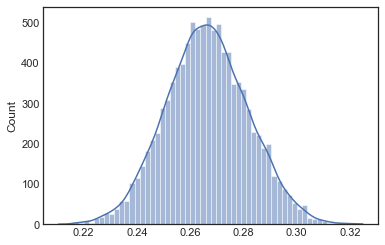

In [9]:
sns.histplot(mcmcfit.get_samples()['phi'], kde=True);

In [12]:
hdi = arviz.hdi(np.array(mcmcfit.get_samples()['phi']))
hdi, hdi[1] - hdi[0]

(array([0.23710737, 0.29485205], dtype=float32), 0.05774468)

- The result is a posterior mean for θ of 0.27 with an 90% central posterior interval of (0.24,0.29). With more data, such as from more players or from the rest of the season, the posterior approaches a delta function around the maximum likelihood estimate and the posterior interval around the centeral posterior intervals will shrink. 
- Nevertheless, even if we know a player’s chance of success exactly, there is a large amount of uncertainty in running K binary trials with that chance of success; using a binomial model fundamentally bounds our prediction accuracy.

- Although this model will be a good baseline for comparison, we have good reason to believe from a large amount of prior data (players with as many as 10,000 trials) that **it is very unlikely that all players have the same chance of success.**

## Model 2: No Pooling

- A model with **no pooling** involves a separate chance-of-success parameters  $\theta_n\in[0,1]$ for each item $n$.
- The prior on each $\theta_n$ is uniform
$$
    p(\theta_n) = \mathrm{Uniform}(\theta_n|0,1)
$$
- and the $\theta_n$ are assumed to be independent,
$$
    p(\theta) = \prod_{n=1}^N\mathrm{Uniform}(\theta_n|0,1)
$$

- Assuming each player’s at-bats are independent Bernoulli trials, the sampling distribution for each player’s number of hits $y_n$ is modeled as
$$
    p(y_n|\theta_n) = \mathrm{Binomial}(y_n|K_n, \theta_n) \quad\mbox{likelihood}
$$
- Assuming $y_n$ are independent (conditioned on $\theta$) leads to the total data likelihood
$$
    p(y|\theta) = \prod_{n=1}^N\mathrm{Binomial}(y_n|K_n,ϕ)
$$


In [13]:
def np_model(hits=None, atbats=None):    
    size_y = len(hits) if hits is not None else 1
    with npr.plate('plate', size=size_y):
        theta = npr.sample('theta', dist.Uniform(0, 1))
        y = npr.sample('y', dist.Binomial(total_count=atbats, probs=theta), obs=hits)

In [14]:
data = dict(hits=df.Hits.values, atbats=df.AtBats.values)
mcmcfit = gomcmc(np_model, data)

sample: 100%|██████████| 11000/11000 [00:10<00:00, 1003.49it/s, 7 steps of size 5.46e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
  theta[0]      0.40      0.07      0.40      0.29      0.52  19759.92      1.00
  theta[1]      0.38      0.07      0.38      0.27      0.50  23342.60      1.00
  theta[2]      0.36      0.07      0.36      0.25      0.48  23011.60      1.00
  theta[3]      0.34      0.07      0.34      0.23      0.45  22315.64      1.00
  theta[4]      0.32      0.07      0.32      0.21      0.43  20945.54      1.00
  theta[5]      0.32      0.07      0.32      0.21      0.43  22120.39      1.00
  theta[6]      0.30      0.07      0.29      0.18      0.40  23262.30      1.00
  theta[7]      0.28      0.06      0.27      0.17      0.38  21588.50      1.00
  theta[8]      0.26      0.06      0.25      0.16      0.36  21160.15      1.00
  theta[9]      0.26      0.06      0.25      0.15      0.36  21022.88      1.00
 theta[10]      0.23      0.06      0.23      0.13      0.33  23021.81      1.00
 theta[11]      0.23      0

In [15]:
hdi = arviz.hdi(np.array(mcmcfit.get_samples()['theta'][:,0]))
hdi, hdi[1] - hdi[0]

(array([0.2736489, 0.5375167], dtype=float32), 0.26386783)

### Appreciation
- Now there is a separate line for each item’s estimated $θ_n$. 
- The posterior mode is the maximum likelihood estimate, but that requires running an optimizer to find; the posterior mean and median will be reasonably close to the posterior mode despite the skewness (the posterior can be shown analytically to be a Beta distribution).
- Each std and 90% interval is much wider than the estimated interval for the population in the complete pooling model
    - std is in [0.05, 0.07] whereas std = 0.02 for complete pooling model
    - HDI is very much larger than that of the complete pooling model.
    - this is to be expected—there are only 45 data items for each parameter here as opposed to 810 in the complete pooling case. 
    - If the items each had different numbers of trials, the intervals would also vary based on size.

- As the estimated chance of success goes up toward 0.5, the 80% intervals gets wider. This is to be expected for chance of success parameters, because 
    1. the number of samples is smaller now, and 
    2. the standard deviation of a random variable distributed as Binomial(K,θ) is 
$$
    std = \sqrt{\frac{\theta (1 - \theta)}{K}}
$$

- The **no-pooling** model provides better MCMC mixing than the complete pooling model as indicated by the effective sample size and convergence diagnostics $\hat R$; 
    - although not in and of itself meaningful, it is often the case that badly misspecified models provide difficult computation (a result Andrew Gelman has dubbed “The Folk Theorem”).

- Based on our existing knowledge of baseball, the no-pooling model is almost certainly 
    1. overestimating the high abilities and 
    2. underestimating lower abilities 
    - Ted Williams, 30 years prior to the year this data was collected, was the last player with a 40% observed success rate over a season, whereas 20% is too low for all but a few rare defensive specialists.

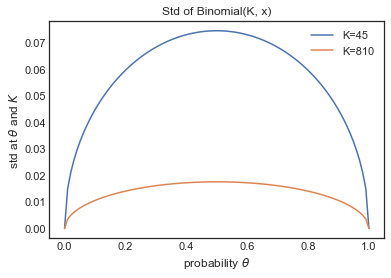

In [19]:
# std of Binomial(K, p) for two Ks.
K = 45
x = np.linspace(0, 1, 100)
plt.plot(x, np.sqrt(x*(1-x)/K), label=f'K={K}');
K = 810
plt.plot(x, np.sqrt(x*(1-x)/K), label=f'K={K}');
plt.title('Std of Binomial(K, x)'); 
plt.xlabel('probability $\\theta$');
plt.ylabel('std at $\\theta$ and $K$')
plt.legend();

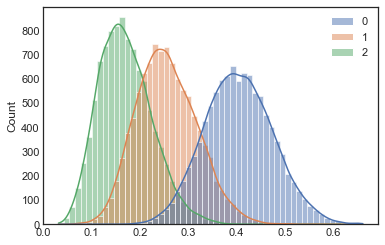

In [23]:
sns.histplot(mcmcfit.get_samples()['theta'][:,[0, 8, 17]], kde=True);

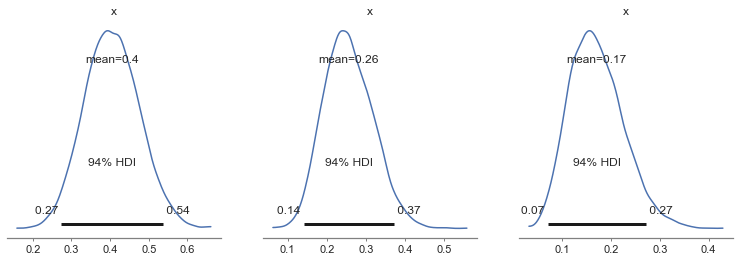

In [22]:
import arviz
trace = get_samples(mcmcfit.get_samples())
var = [0, 8, 17]
nplots = len(var)
fig, axes = plt.subplots(1, nplots, figsize=(13,4))
for i in range(nplots):
    arviz.plot_posterior(trace[f'theta_{var[i]}'], ax=axes[i]);

## Model 3: Partial Pooling (Chance of Success)

Complete pooling provides estimated abilities that are too narrowly distributed for the items and removes any chance of modeling population variation. Estimating each chance of success separately without any pooling provides estimated abilities that are too broadly distributed for the items and hence too variable. Clearly some amount of pooling between these two extremes is called for. But how much?

A hierarchical model treats the players as belonging to a population of players. The properties of this population will be estimated along with player abilities, implicitly controlling the amount of pooling that is applied. The more variable the (estimate of the) population, the less pooling is applied.

Mathematically, the hierarchical model places a prior on the abilities with parameters that are themselves estimated. In this case, we will assume a beta distribution as the prior as it is scaled to values in [0,1],

p(θn|α,β) = Beta(θn|α,β),

where α,β>0 are the parameters of the prior. The beta distribution is the conjugate prior for the binomial, meaning that the posterior is known to be a beta distribution. This also allows us to interpret the prior’s parameters as prior data, with α−1 being the prior number of successes and β−1 being the prior number of failures, and α=β=1 corresponding to no prior observations and thus a uniform distribution. Each θn will be modeled as conditionally independent given the prior parameters, so that the complete prior is

p(θ|α,β)=∏n=1NBeta(θn|α,β).

The parameters α and β are themselves given priors (sometimes called hyperpriors). Rather than parameterize α and β directly, we will instead put priors on ϕ∈[0,1] and κ>0, and then define

α=κϕ

and

β=κ(1−ϕ).

This reparameterization is convenient, because

ϕ=αα+β is the mean of a variable distributed as Beta(α,β), and

κ=α+β is the prior count plus two (roughly inversely related to the variance).

We will follow Gelman et al. (2013, Chapter 5) in providing a prior that factors into a uniform prior on ϕ,

p(ϕ)=Uniform(ϕ|0,1),

and a Pareto prior on κ,

p(κ)=Pareto(κ|1,1.5)∝κ−2.5.

with the restriction κ>1. In general, for functions f and g, we write f(x)∝g(x) if there is some constant c such that f(x)=cg(x). The first argument to the Pareto distribution is a bound ϵ>0, which in turn requires the outcome κ>ϵ; this is required so that the distribution can be normalized to integrate to 1 over its support. The value ϵ=1 is a conservative choice for this problem as we expect in the posterior, κ will be much greater than 1. The constraint κ>1 must therefore be included in the Stan parameter declaration, because Stan programs require support on the parameter values that satisfy their declared constraints.